# 生成数据

In [53]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np

def func(x):
    y = np.sin(x) + x
    return y

train_x = np.random.rand(1000, 1) * np.pi * 2
train_y = func(train_x)

test_x = np.random.rand(200, 1) * np.pi * 2
test_y = func(test_x)

data = {
    'train': (train_x, train_y),
    'test': (test_x, test_y)
}


# 数据集

## 数据集的定义

In [54]:
class SinDataset(Dataset):
    """Dataset of deformed boards."""

    def __init__(self, data, transform=None, train=True):
        """
        Arguments:
            transform (callable, optional): Optional transform to be applied on a sample.
            train (bool, optional): load train data or test data.
        """
        if train:
            self.data = data['train']
        else:
            self.data = data['test']
        self.transform = transform

    def __len__(self):
        return self.data[0].shape[0]

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()
        x = self.data[0][idx]
        y = self.data[1][idx]

        sample = {'x': x, 
                  'y': y}

        if self.transform:
            sample_final = self.transform(sample)

        else:
            sample_final = sample

        return sample_final

## 转换方法的定义

In [55]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        x, y = sample['x'], sample['y']
        return {'x': torch.from_numpy(x).to(torch.float32),
                'y': torch.from_numpy(y).to(torch.float32)}

## 数据集的生成

In [56]:
train_dataset = SinDataset(data, transform=transforms.Compose([
                                               ToTensor()
                                           ]), train=True)
test_dataset = SinDataset(data, transform=ToTensor(), train=False)
loaders = {
    'train' : DataLoader(train_dataset,
                         batch_size=50,
                         shuffle=True,
                         num_workers=0),
    
    'test'  : DataLoader(test_dataset, 
                         batch_size=10,
                         shuffle=True,
                         num_workers=0),
}

# 模型定义

In [57]:
import torch

class TinyModel(torch.nn.Module):

    def __init__(self, hidden_dim=100):
        super(TinyModel, self).__init__()
        self.linear1 = torch.nn.Linear(1, hidden_dim)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.reshape([x.shape[0], -1])
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

# 求解器定义

In [58]:
class ModelSolver(object):
    def __init__(self, model, dataloaders, **kwargs):
        """
        Construct a new Solver instance.
        ## Required arguments:
        - model
        - dataloaders

        ## Optional arguments:

        ### training details
        - learning_rate(int): Learning rate of optimizer.
        - num_epochs(int): The number of epochs to run for during training.
        - weight_decay(float)

        ### output
        - print_every(int): Training losses will be printed every print_every
          iterations.
        - verbose(bool): Print training result or not.
        """
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = model
        self.model = self.model.to(self.device)
        self.dataloaders = dataloaders

        # Unpack keyword arguments
        # training stategies
        self.learning_rate = kwargs.pop("learning_rate", 1e-5)
        self.num_epochs = kwargs.pop("num_epochs", 10)
        weight_decay = kwargs.pop("weight_decay", 0.01)
        self.optim = torch.optim.Adam(self.model.parameters(), self.learning_rate, weight_decay=weight_decay)

        # output
        self.print_every = kwargs.pop("print_every", 1)
        self.verbose = kwargs.pop("verbose", True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ", ".join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError("Unrecognized arguments %s" % extra)

        self._reset()

    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this
        manually.
        """
        # Set up some variables for book-keeping
        self.loss_history = []

    def _step(self, batch):
        """
        Make a single gradient update. This is called by train() and should not
        be called manually.
        """
        x = batch['x'].to(self.device)
        y = batch['y'].to(self.device)
        output = self.model(x)
        loss = self.loss(output, y)
        self.loss_history.append(loss.detach().cpu().numpy())

        self.optim.zero_grad()
        loss.backward()
        self.optim.step()

    def train(self):
        """
        Run optimization to train the model.
        """
        self.model.train()

        iterations_per_epoch = max(len(self.dataloaders['train']), 1)
        num_iterations = self.num_epochs * iterations_per_epoch
        
        t = 0
        best_loss = 10
        for e in range(self.num_epochs):
            # Update parameters
            for i, batch in enumerate(self.dataloaders['train']):
                self._step(batch)
                # Maybe print training loss
                if self.verbose and t % self.print_every == 0:
                    print(
                        "(Training Epoch %d Iteration %d / %d) loss: %f"
                        % (e + 1, t + 1, num_iterations, self.loss_history[-1])
                    )
                t += 1
            # Validation
            loss = self.val()
            if loss < best_loss:
                best_loss = loss
                self.best_model = self.model
            print("(Validation Epoch %d) loss: %f" % (e + 1, loss))
            
        self.model = self.best_model

    def val(self):
        """
        Run test.
        """
        loss_history = []
        self.model.eval()
        with torch.no_grad():
            for i, batch in enumerate(self.dataloaders['test']):

                x = batch['x'].to(self.device)
                y = batch['y'].to(self.device)
                output = self.model(x)
                loss_history.append(self.loss(output, y))
                
        loss = sum(loss_history)/len(loss_history)
        return loss

    def loss(self, log_prob, labels):
        loss_function = torch.nn.L1Loss()
        return loss_function(log_prob, labels)

# 训练模型

In [59]:
tinymodel = TinyModel(hidden_dim=1000)
solver = ModelSolver(tinymodel, 
                     loaders, 
                     num_epochs=30, 
                     learning_rate=5e-4,
                     print_every=10)
solver.train()

(Training Epoch 1 Iteration 1 / 600) loss: 1.983703
(Training Epoch 1 Iteration 11 / 600) loss: 0.714460
(Validation Epoch 1) loss: 0.514239
(Training Epoch 2 Iteration 21 / 600) loss: 0.521348
(Training Epoch 2 Iteration 31 / 600) loss: 0.407045
(Validation Epoch 2) loss: 0.400732
(Training Epoch 3 Iteration 41 / 600) loss: 0.393687
(Training Epoch 3 Iteration 51 / 600) loss: 0.305814
(Validation Epoch 3) loss: 0.332003
(Training Epoch 4 Iteration 61 / 600) loss: 0.349712
(Training Epoch 4 Iteration 71 / 600) loss: 0.244991
(Validation Epoch 4) loss: 0.288200
(Training Epoch 5 Iteration 81 / 600) loss: 0.297334
(Training Epoch 5 Iteration 91 / 600) loss: 0.333935
(Validation Epoch 5) loss: 0.273208
(Training Epoch 6 Iteration 101 / 600) loss: 0.230322
(Training Epoch 6 Iteration 111 / 600) loss: 0.229006
(Validation Epoch 6) loss: 0.265785
(Training Epoch 7 Iteration 121 / 600) loss: 0.239293
(Training Epoch 7 Iteration 131 / 600) loss: 0.212254
(Validation Epoch 7) loss: 0.270129
(Tr

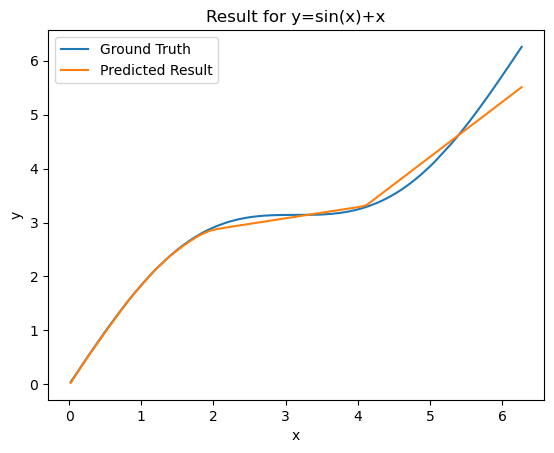

In [61]:
import matplotlib.pyplot as plt


test_x.sort(axis=0)
test_y = np.sin(test_x) + test_x

predicted_y = None
solver.model.eval()
predicted_y = solver.model(torch.from_numpy(test_x).to(torch.float32))
predicted_y = predicted_y.detach().numpy()

plt.plot(test_x, test_y, label='Ground Truth')
plt.plot(test_x, predicted_y, label='Predicted Result')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Result for y=sin(x)+x')
plt.legend()
plt.show()